# GPU in colab
First, you'll need to enable GPUs for the notebook:
*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down




In [ ]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-05-11 18:32:32.585014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:32:32.585219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:32:32.585324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:32:32.585481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:32:32.585588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [ ]:
from os import path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from google.colab import drive, files

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Importing CIFAR10 data set 

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
X_train.shape, y_train.shape, X_train.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (50000, 32, 32, 3), (10000, 1))

In [ ]:
numb_cats = y_train.max() + 1 # number of different categories

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, numb_cats) # converting to vector of probabilities
y_test =  tf.keras.utils.to_categorical(y_test, numb_cats)

In [ ]:
X_train.max(), X_train.min() # checking if images are rescaled

(255, 0)

# Preprocessing data via Keras Tools

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, # rescaling 
    featurewise_center=True, # if True it sets the mean to 0
    featurewise_std_normalization=True, # if True sets stdev to 1
    validation_split=0.2# float fraction of images for validation
    )

# other patemeters of ImageDataGenerator are found here:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

BATCH_SIZE = 64 # mini batch size

datagen.fit(X_train) # preprocessing data by applying the generator to our train dataset
datagen.fit(X_test) # applying the generator to our train dataset




In [ ]:
train_dataset = datagen.flow(
    X_train, # Selecting X train
    y_train, # Selecting target
    batch_size=BATCH_SIZE, # Specifying the size of mini-batch
    shuffle=True, # if True it shuffles the data randomly
    subset='training' # Picks the training subset of the data 
    #so 1 - validation_split fraction of dataset
    )

val_dataset = datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation'
    )

test_dataset =  datagen.flow(
    X_test,
    y_test,
    batch_size=1 # with test data batch size should be 1
    )

# Model of a network LeNet5 

Here we implement the original LeNet5. 

Note that it uses tanh activation function in the middle layers which can cause vanishing gradient issue. 

We will find out that the original LeNet5 does not do very well on CIFAR10. 

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [ ]:
model = tf.keras.Sequential()
# C1 layer
model.add(tf.keras.layers.Conv2D(
    filters=6,
    kernel_size=(5, 5),
    activation='tanh',
    input_shape=input_shape)
)
# S2 Layer
model.add(tf.keras.layers.AveragePooling2D((2, 2))) # this performs downsampling 
# C3 layer
model.add(tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(5, 5),
    activation='tanh',
    input_shape=input_shape)
)
# S4 Layer
model.add(tf.keras.layers.AveragePooling2D((2, 2))) # this performs downsampling 
# C5 layer
model.add(tf.keras.layers.Flatten()) # flattening 
model.add(tf.keras.layers.Dense(120, activation="tanh"))
# F6 
model.add(tf.keras.layers.Dense(84, activation="tanh"))
model.add(tf.keras.layers.Dense(numb_cats, activation='softmax')) # output layer

### Callbacks

In [ ]:
# saving best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )


In [ ]:
# early stopping - prevents overstopping, lr_scheduler, tensorboard_callback]fitting
# it stops the training if your model stops improving for specified number of epochs
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # we monitor the loss for the validation 
    min_delta=0, # minimum change in the monitored quantity to qualify as an improvement
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    verbose=1, # how verbal the description should be
    mode='min', # In min mode, training will stop when the quantity monitored has stopped decreasing
    baseline=None, # Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
    restore_best_weights=False # Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
)




In [ ]:
# At the beginning of every epoch, 
# this callback gets the updated learning rate value 
# from scheduler function 

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# TensorBoard is a visualization tool provided with TensorFlow.
# This callback logs events for TensorBoard, including:
# Metrics summary plots
# Training graph visualization
# Weight histograms
# Sampled profiling

logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
# collecting all callbacks together

callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]

## Optimizer & Compliing the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

## Training the model

In [ ]:
EPOCHS = 10

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.n // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_dataset.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/10


2022-05-11 18:32:47.353040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8303
2022-05-11 18:32:48.740085: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


617/625 [============================>.] - ETA: 0s - loss: 1.7398 - accuracy: 0.3875
Epoch 00001: val_accuracy improved from -inf to 0.44121, saving model to model.h5
625/625 [==============================] - 4s 3ms/step - loss: 1.7384 - accuracy: 0.3878 - val_loss: 1.5958 - val_accuracy: 0.4412 - lr: 0.0010
Epoch 2/10
599/625 [===========================>..] - ETA: 0s - loss: 1.5303 - accuracy: 0.4612
Epoch 00002: val_accuracy improved from 0.44121 to 0.47907, saving model to model.h5
625/625 [==============================] - 1s 2ms/step - loss: 1.5286 - accuracy: 0.4615 - val_loss: 1.4656 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 3/10
617/625 [============================>.] - ETA: 0s - loss: 1.4103 - accuracy: 0.4996
Epoch 00003: val_accuracy improved from 0.47907 to 0.50871, saving model to model.h5
625/625 [==============================] - 1s 2ms/step - loss: 1.4097 - accuracy: 0.5002 - val_loss: 1.3780 - val_accuracy: 0.5087 - lr: 0.0010
Epoch 4/10
599/625 [===================

### Model summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)              

## Visualising loss and accuracy curves by MATPLOTLIB

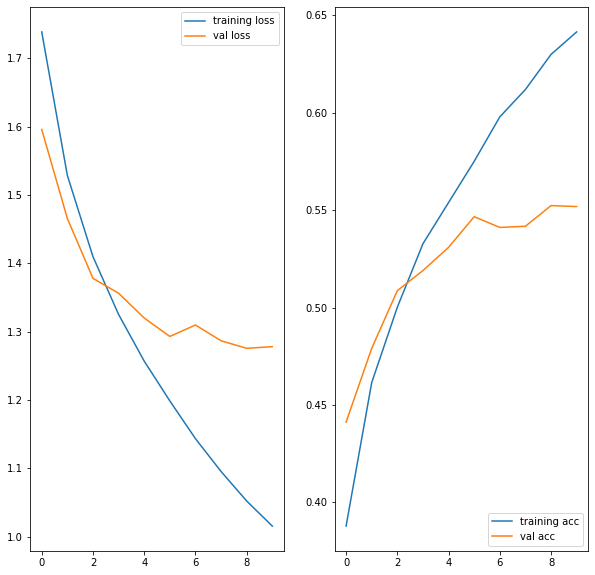

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='lower right')

plt.show()

## Viewing TENSORBOARD

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../logs/scalars

## Loading BEST WEIGHTS

In [ ]:
# loading the best weights
model.load_weights("model.h5")

## Evaluating the model on unseen TEST DATA

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

10000/10000 [==============================] - 10s 996us/step - loss: 1.2819 - accuracy: 0.5548
Test accuracy: 0.5547999739646912, test loss: 1.2819151878356934


# Transfer Learning

In transfer learning we will be using pre-trained models from 

https://keras.io/api/applications/

The models have been trained on ImageNet Dataset

We will be removing their Fully Connected Layers (Top Layers) and training these. 

Training any of the above models would take a very long time. Re-using their weights and training only a few layers is relatively quick. 

From the List we picked Inception, the winner of ImageNet Challenge in 2015.

In [ ]:
res_net_img_size  = (224,)
# The Winner of ImageNet Challenge in 2014 InceptionV1 (formerly known as GoogleLeNet)
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=2*res_net_img_size  + (3,),
    pooling=None,
    classifier_activation="softmax",
)

If we want to freeze all the layers of the network then we run 

``base_model.trainable = False``

If some layers (from the end to beginnning) then we can iterate through all the layers and set the parameter trainable to false if we don't want to train them

``layer.trainable.False``

In [ ]:
base_model.trainable = False
# num_to_train = 10
# for layer in base_model.layers[-num_to_train:]: # uncomment if you with to train last 10 layers
#     layer.trainable=True

The images from ImageNet are $224 \times 224$. We can resize out input images. 

## Setting up the model

In [ ]:
tl_model = tf.keras.Sequential()
tl_model.add(tf.keras.layers.Resizing(res_net_img_size[0], res_net_img_size[0]))
tl_model.add(base_model)
tl_model.add(tf.keras.layers.Flatten()) # flattening 
# Batch normalization applies a transformation that maintains the mean output 
# close to 0 and the output standard deviation close to 1.
tl_model.add(tf.keras.layers.BatchNormalization())
tl_model.add(tf.keras.layers.Dense(1024, activation="relu"))
tl_model.add(tf.keras.layers.Dropout(0.3))
tl_model.add(tf.keras.layers.BatchNormalization())
tl_model.add(tf.keras.layers.Dense(128, activation="relu"))
tl_model.add(tf.keras.layers.Dropout(0.3))
tl_model.add(tf.keras.layers.Dense(numb_cats, activation='softmax')) # output layer

In [ ]:
numb_cats

10

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
tl_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "tl_model.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )

callbacks_list = [checkpoint]

In [ ]:
EPOCHS = 2

## Training the model

In [ ]:
history = tl_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.n // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_dataset.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/2
625/625 [==============================] - ETA: 0s - loss: 0.9746 - accuracy: 0.6888
Epoch 00001: val_accuracy improved from -inf to 0.77123, saving model to tl_model.h5


2022-05-11 18:05:24.944180: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 209715200 exceeds 10% of free system memory.
2022-05-11 18:05:25.517171: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 209715200 exceeds 10% of free system memory.


625/625 [==============================] - 61s 93ms/step - loss: 0.9746 - accuracy: 0.6888 - val_loss: 0.6777 - val_accuracy: 0.7712
Epoch 2/2
625/625 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.8080
Epoch 00002: val_accuracy improved from 0.77123 to 0.78816, saving model to tl_model.h5


2022-05-11 18:06:21.980461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 209715200 exceeds 10% of free system memory.
2022-05-11 18:06:22.519893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 209715200 exceeds 10% of free system memory.


625/625 [==============================] - 57s 91ms/step - loss: 0.5687 - accuracy: 0.8080 - val_loss: 0.6463 - val_accuracy: 0.7882


## Evaluating the model

In [ ]:
test_loss, test_acc = tl_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

10000/10000 [==============================] - 137s 14ms/step - loss: 0.6650 - accuracy: 0.7862
Test accuracy: 0.7861999869346619, test loss: 0.6649535894393921
